In [1]:
import time
import os
from stable_baselines3 import PPO  #PPO

In [2]:
from carla_park_env import CarlaParkingEnv

In [3]:
print('setting folders for logs and models')
models_dir = f"models/{int(time.time())}/"
logdir = f"logs/{int(time.time())}/"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

setting folders for logs and models


In [4]:
print('connecting to env..')
env = CarlaParkingEnv()

connecting to env..


In [5]:
env.reset()
print('Env has been reset as part of launch')

Env has been reset as part of launch


In [6]:
model = (
    PPO(
        'MlpPolicy',
        env,
        verbose=2,
        learning_rate=1e-5,
        clip_range=0.5,  #clip_range en PPO para permitir más exploración:
        tensorboard_log=logdir,
        device='cuda'
    )
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\ruben\anaconda3\envs\carla-sim\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  "You provided an OpenAI Gym environment. "


In [7]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np
import matplotlib.pyplot as plt

In [8]:
class ProgressCallback(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str):
        super(ProgressCallback, self).__init__()
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.rewards = []  # Para almacenar las recompensas por episodio
        self.episode_rewards = []  # Para almacenar la recompensa promedio por episodio
        self.episodes = 0  # Contador de episodios

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Usar la recompensa registrada en 'rewards' directamente
            mean_reward = np.mean(self.locals['rewards'])  # Promedio de recompensas recientes

            self.rewards.append(mean_reward)
            self.episodes += 1  # Aumenta el número de episodios
            print(f"Step: {self.n_calls}, Mean Reward (últimos {self.check_freq} pasos): {mean_reward}")
        
        return True

    def _on_training_end(self) -> None:
        # Al finalizar el entrenamiento, graficar recompensas vs episodios
        self.plot_rewards()
        
    def plot_rewards(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(self.episodes), self.rewards, label="Recompensa Promedio")
        plt.xlabel("Episodios")
        plt.ylabel("Recompensa Promedio")
        plt.title("Recompensa Promedio por Episodio")
        plt.legend()
        plt.grid()
        plt.show()

Logging to logs/1729585704/PPO_2
Recompensa por acortar distancias: +  0.9156947947468153
Penalización por parar muy lejos: -  0.16592873017928675
Penalización por duración del episodio: -  0.26915503235680127
Recompensa por acortar distancias: +  0.9156947947468153
Penalización por duración del episodio: -  0.26945210791562124
Recompensa por acortar distancias: +  0.9156948315576056
Penalización por parar muy lejos: -  0.165928796171837
Penalización por duración del episodio: -  0.2697533494953414
Recompensa por acortar distancias: +  0.9156948904548395
Penalización por parar muy lejos: -  0.1659289017599611
Penalización por duración del episodio: -  0.2700616228709736
Recompensa por acortar distancias: +  0.9156950082491956
Penalización por parar muy lejos: -  0.1659291129363708
Penalización por duración del episodio: -  0.27036160524201436
Recompensa por acortar distancias: +  0.9156950082491956
Penalización por duración del episodio: -  0.27067567219394545
Recompensa por acortar di

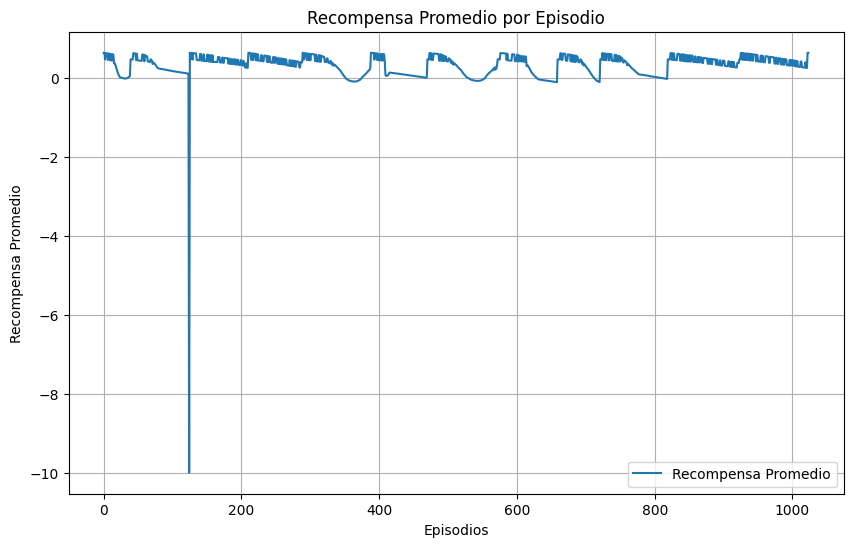

In [17]:
total_timesteps = 10000 # how many timesteps you want to train for
progress_callback = ProgressCallback(check_freq=10, log_dir=logdir)
model.learn(total_timesteps=total_timesteps, callback=progress_callback)
model.save("ppo_carla_parking")

In [10]:
TIMESTEPS = 5  # how long is each training iteration - individual steps
iters = 0

import matplotlib.pyplot as plt
import numpy as np

num_episodes = 10
rewards_per_episode = []

In [11]:
# while iters < 5:  # how many training iterations you want
#     iters += 1
#     print('Iteration ', iters, ' is to commence...')
#     model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=f"PPO")
#     print('Iteration ', iters, ' has been trained')
#     model.save(f"{models_dir}/{TIMESTEPS * iters}")

In [12]:
# # Evaluar el modelo después de cada iteración
# for _ in range(num_episodes):
#     obs = env.reset()
#     done = False
#     episode_reward = 0
#     while not done:
#         action, _states = model.predict(obs)
#         obs, reward, done, info = env.step(action)
#         episode_reward += reward
#     rewards_per_episode.append(episode_reward)
# 
# 


In [13]:
# # --- Generar gráfico de recompensas ---
# plt.plot(rewards_per_episode)
# plt.title('Recompensas por Episodio')
# plt.xlabel('Episodio')
# plt.ylabel('Recompensa Total')
# plt.grid(True)
# plt.show()

In [14]:
spectator = env.world.get_spectator()

transform = spectator.get_transform()
location = transform.location
rotation = transform.rotation

print(location, rotation)

Location(x=18.633802, y=-19.904999, z=7.794066) Rotation(pitch=-29.543756, yaw=-117.807945, roll=0.000025)


In [15]:
import tensorflow as tf

print("GPU disponible:", tf.config.list_physical_devices())

GPU disponible: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


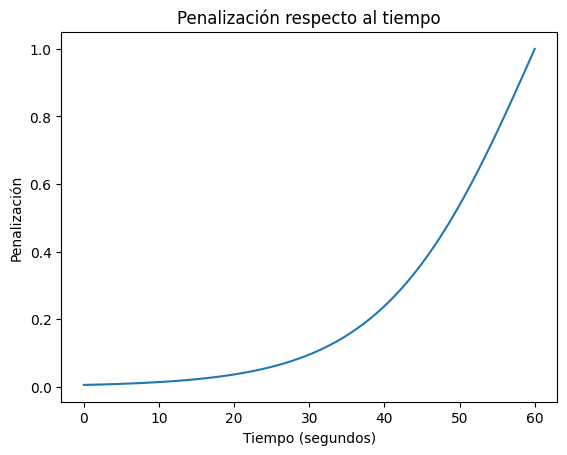

In [16]:
# v es el valor que se quiere penalizar
# k controla la inclinación de la curva (qué tan rápido crece la penalización)
# m controla la penalización maxima
# p controla la magnitud de la penalización

mm=60

def punish_logistic(v, k=0.1, m=mm, p=1):
    logistic = 2 / (1 + np.exp(-k * (v - m)))
    return logistic * p

# Generar valores de tiempo entre 0 y 60
tiempos = np.linspace(0, mm, 100)
penalizaciones = punish_logistic(tiempos)

# Graficar
plt.plot(tiempos, penalizaciones)
plt.title("Penalización respecto al tiempo")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Penalización")
plt.show()

tensorboard --logdir='E:\UADY\CARLA\CARLA_Latest\WindowsNoEditor\PythonAPI\examples\Ruben\Parking training\logs'